<a href="https://colab.research.google.com/github/Sadia7766/Assignment/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/shapes'
img_size = (224, 224)
batch_size = 32
seed = 42

In [9]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, # Assuming the extracted directory is named 'archive'
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 691 files belonging to 4 classes.


In [10]:
# Split manually: 70% train, 15% val, 15% test
dataset_size = len(full_ds)
train_size = int(0.7 * dataset_size)
val_size = int(0.3 * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds = full_ds.take(train_size)
rest_ds = full_ds.skip(train_size)
val_ds = rest_ds.take(val_size)
test_ds = rest_ds.skip(test_size)

In [11]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [12]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

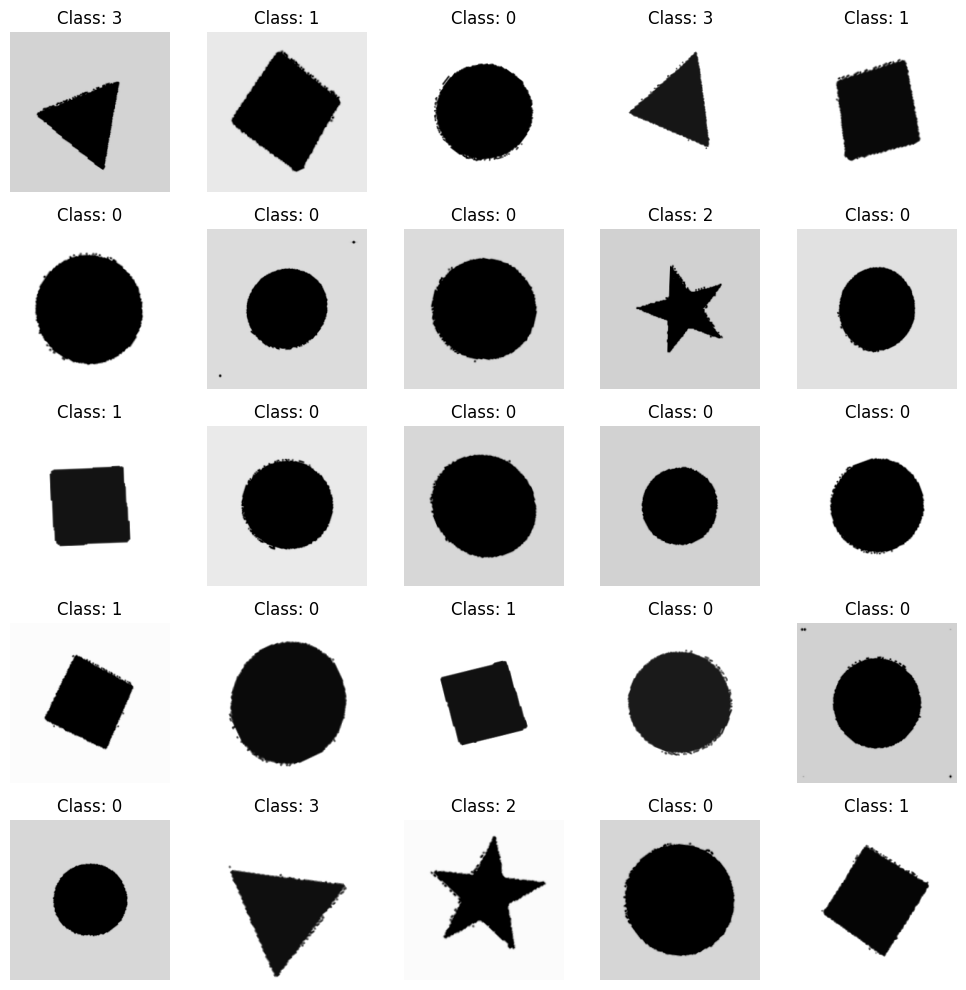

In [14]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [15]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),
    Conv2D(16, (4, 4), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 221, 221, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,595,892 (21.35 MB)

 Trainable params: 5,595,892 (21.35 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train
history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4724 - loss: 1.1293 - val_accuracy: 0.8438 - val_loss: 0.3595
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8397 - loss: 0.4208 - val_accuracy: 0.9062 - val_loss: 0.2485
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9287 - loss: 0.1964 - val_accuracy: 0.9792 - val_loss: 0.0687
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9774 - loss: 0.0941 - val_accuracy: 0.9479 - val_loss: 0.1855
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9890 - loss: 0.0433 - val_accuracy: 0.9844 - val_loss: 0.0500
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9874 - loss: 0.0286 - val_accuracy: 0.9896 - val_loss: 0.0462
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9929 - loss: 0.0149 - val_accuracy: 0.9948 - val_loss: 0.0299
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9921 - loss: 0.0226 - val_accuracy: 0.9948 - val_loss:

In [18]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 1.0000 - loss: 7.1556e-04
Test Accuracy: 1.00


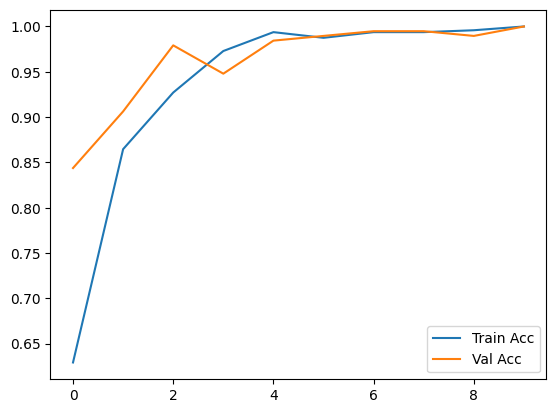

In [19]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 434s 29s/step - accuracy: 0.7213 - loss: 13.1533 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 450s 31s/step - accuracy: 0.9982 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 483s 29s/step - accuracy: 1.0000 - loss: 7.8811e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 431s 29s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 441s 29s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
6/6 ━━━━━━━━━━━━━━━━━━━━ 114s 18s/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Accuracy: 1.00


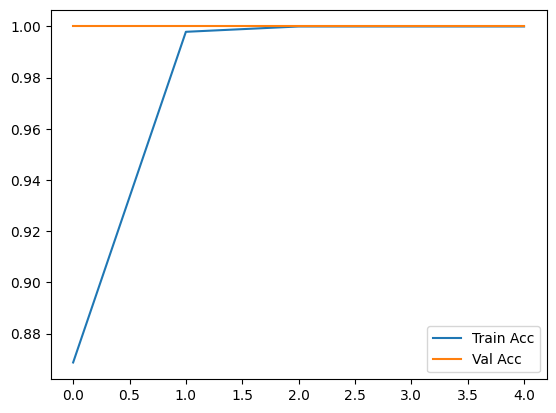

In [20]:
# prompt: train using VGG16

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# ... (Your existing code for data loading and preprocessing) ...

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()
